# A Data-Driven Approach to Estimating Calories in Recipes

**Name(s)**: Keanu Ventura

**Website Link**: [https://keanuventura.github.io/dsc80-final-project/](https://keanuventura.github.io/dsc80-final-project/)

In [29]:
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

from dsc80_utils import * # Feel free to uncomment and use this.

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Step 1: Introduction

In [2]:
question = 'What is the relationship between the cooking time and average rating of recipes?'
question

'What is the relationship between the cooking time and average rating of recipes?'

## Step 2: Data Cleaning and Exploratory Data Analysis

In [3]:
recipes = pd.read_csv('RAW_recipes.csv')
interactions = pd.read_csv('interactions.csv')
merged = recipes.merge(interactions, left_on='id', right_on='recipe_id', how='left').drop(columns='recipe_id')
merged['rating'] = merged['rating'].replace(0, np.nan)
merged['avg_rating'] = merged.groupby('id')['rating'].transform('mean')
cleaned = merged[merged['minutes'] <= 500]
cleaned

,name,id,minutes,contributor_id,...,date,rating,review,avg_rating
0,1 brownies in the world best ever,333281,40,985201,...,2008-11-19,4.0,"These were pretty good, but took forever to ba...",4.0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...,5.0
2,412 broccoli casserole,306168,40,50969,...,2008-12-31,5.0,This was one of the best broccoli casseroles t...,5.0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...,3.0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm...",3.0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,2014-11-01,NaN,I work at a Cookies By Design and can say this...,3.0


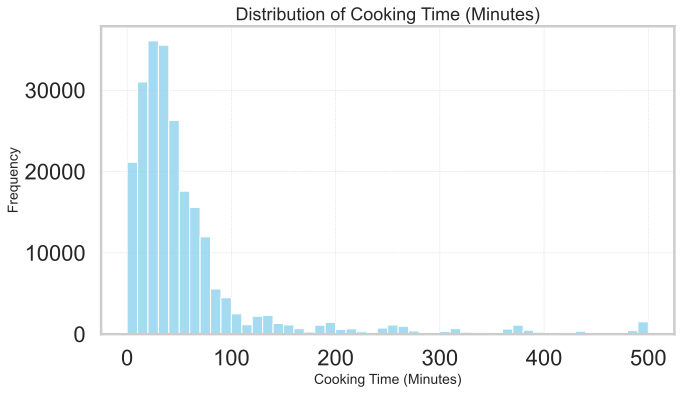

In [4]:
plt.figure(figsize=(10,6))
sns.histplot(cleaned['minutes'], bins=50, kde=False, color='skyblue', edgecolor='white')
plt.title('Distribution of Cooking Time (Minutes)', fontsize=18)
plt.xlabel('Cooking Time (Minutes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

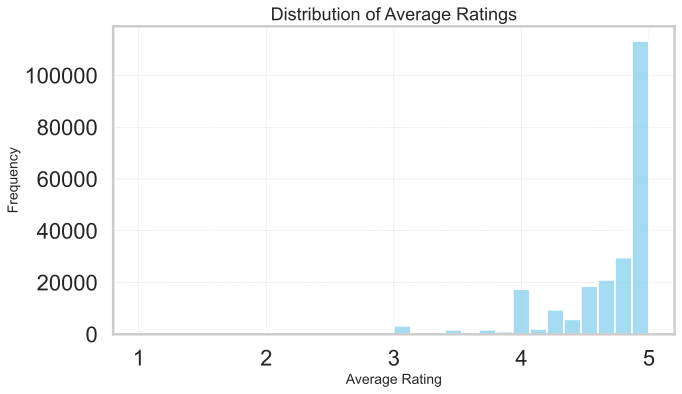

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(cleaned['avg_rating'], bins=30, kde=False, color='skyblue', edgecolor='white')
plt.title('Distribution of Average Ratings', fontsize=18)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

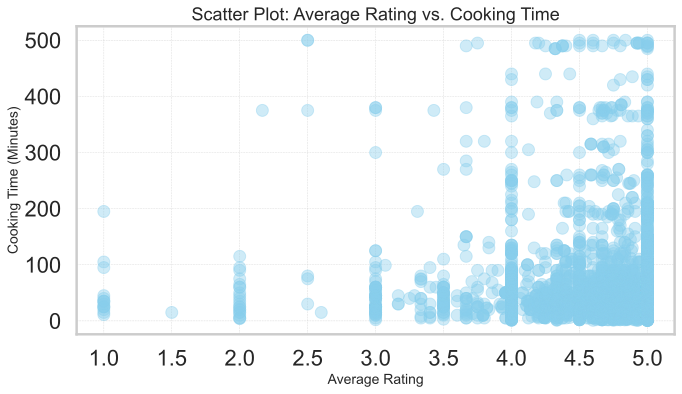

In [6]:
sampled = cleaned.sample(n=5000, random_state=6)

plt.figure(figsize=(10,6))
sns.scatterplot(data=sampled, x='avg_rating', y='minutes', alpha=0.4, color='skyblue', edgecolor=None)
plt.title('Scatter Plot: Average Rating vs. Cooking Time', fontsize=18)
plt.xlabel('Average Rating', fontsize=14)
plt.ylabel('Cooking Time (Minutes)', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

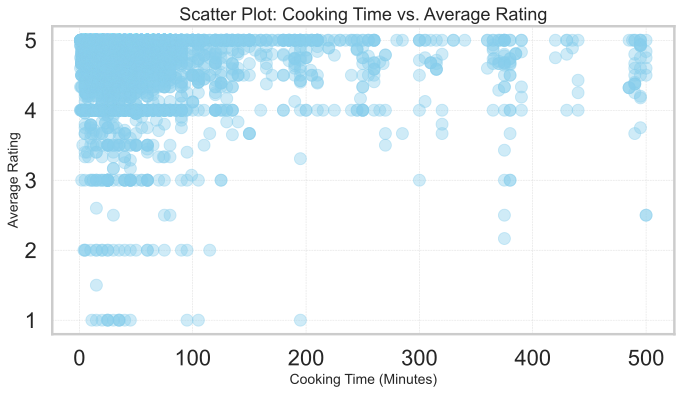

In [7]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=sampled, x='minutes', y='avg_rating', alpha=0.4, color='skyblue', edgecolor=None)
plt.title('Scatter Plot: Cooking Time vs. Average Rating', fontsize=18)
plt.xlabel('Cooking Time (Minutes)', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [8]:
bin_edges = [0, 10, 20, 30, 40, 50, 60, 90, 120, 180, 240, 300, 400, 500]
bin_labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-90', '90-120',
              '120-180', '180-240', '240-300', '300-400', '400-500']
cleaned['time_bins'] = pd.cut(cleaned['minutes'], bins=bin_edges, labels=bin_labels, right=False)
cleaned

,name,id,minutes,contributor_id,...,rating,review,avg_rating,time_bins
0,1 brownies in the world best ever,333281,40,985201,...,4.0,"These were pretty good, but took forever to ba...",4.0,40-50
1,1 in canada chocolate chip cookies,453467,45,1848091,...,5.0,Originally I was gonna cut the recipe in half ...,5.0,40-50
2,412 broccoli casserole,306168,40,50969,...,5.0,This was one of the best broccoli casseroles t...,5.0,40-50
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,1.0,This recipe tastes nothing like the Cookies by...,3.0,20-30
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,5.0,"yummy cookies, i love this recipe me and my sm...",3.0,20-30
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,NaN,I work at a Cookies By Design and can say this...,3.0,20-30


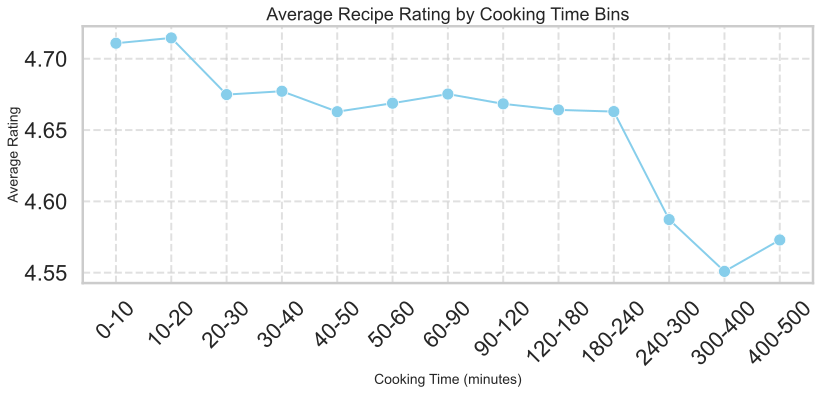

In [9]:
mean_ratings = cleaned.groupby('time_bins', observed=False)['avg_rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_ratings, x='time_bins', y='avg_rating', marker='o', color='skyblue', linewidth=2)

plt.title('Average Recipe Rating by Cooking Time Bins', fontsize=18)
plt.xlabel('Cooking Time (minutes)', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [10]:
cleaned.pivot_table(values='avg_rating',
                    index='time_bins',
                    aggfunc=['mean', 'median', 'min', 'max', 'count'],
                    observed=False)

,mean,median,min,max,count
,avg_rating,avg_rating,avg_rating,avg_rating,avg_rating
time_bins,,,,,
0-10,4.71,4.90,1.0,5.0,21011
10-20,4.71,4.91,1.0,5.0,30721
20-30,4.67,4.86,1.0,5.0,35736
...,...,...,...,...,...
240-300,4.59,4.69,1.0,5.0,3372
300-400,4.55,4.68,1.0,5.0,3913
400-500,4.57,4.73,1.0,5.0,2310


In [11]:
cleaned.groupby('minutes')['avg_rating'].agg(['mean', 'median', 'min', 'max', 'count'])


,mean,median,min,max,count
minutes,,,,,
0,5.00,5.00,5.0,5.0,3
1,4.79,5.00,1.0,5.0,733
2,4.76,4.95,1.0,5.0,2698
...,...,...,...,...,...
496,5.00,5.00,5.0,5.0,4
498,5.00,5.00,5.0,5.0,2
500,4.52,4.74,2.0,5.0,371


## Step 3: Assessment of Missingness

In [12]:
missingness_null_hypothesis_1 = 'The missingness of ratings does not depend on the user ID.'
missingness_alternative_hypothesis_1 = 'The missingness of ratings does depend on the user ID.'
missingness_test_statistic_1 = 'The variance of the proportions of missing ratings across different user IDs.'
print(missingness_null_hypothesis_1)
print(missingness_alternative_hypothesis_1) 
print(missingness_test_statistic_1)

The missingness of ratings does not depend on the user ID.
The missingness of ratings does depend on the user ID.
The variance of the proportions of missing ratings across different user IDs.


In [13]:
cleaned['missing_rating'] = cleaned['rating'].isna().astype(int)
cleaned

,name,id,minutes,contributor_id,...,review,avg_rating,time_bins,missing_rating
0,1 brownies in the world best ever,333281,40,985201,...,"These were pretty good, but took forever to ba...",4.0,40-50,0
1,1 in canada chocolate chip cookies,453467,45,1848091,...,Originally I was gonna cut the recipe in half ...,5.0,40-50,0
2,412 broccoli casserole,306168,40,50969,...,This was one of the best broccoli casseroles t...,5.0,40-50,0
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,This recipe tastes nothing like the Cookies by...,3.0,20-30,0
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,"yummy cookies, i love this recipe me and my sm...",3.0,20-30,0
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,I work at a Cookies By Design and can say this...,3.0,20-30,1


In [14]:
def missingness_perm_test(df, col_to_test, missing_col='missing_rating', n_permutations=1000):

    df_with_two_cols = df[[col_to_test, missing_col]].dropna()

    missingness_proportions = df_with_two_cols.groupby(col_to_test, observed=False)[missing_col].mean()
    observed_variance = missingness_proportions.var()

    perm_variances = []

    for _ in range(n_permutations):

        shuffled_missing = np.random.permutation(df_with_two_cols[missing_col])

        df_with_two_cols_shuffled = df_with_two_cols.copy()
        df_with_two_cols_shuffled[missing_col] = shuffled_missing

        perm_missingness_proportions = df_with_two_cols_shuffled.groupby(col_to_test, observed=False)[missing_col].mean()

        perm_variances.append(perm_missingness_proportions.var())

    p_value = np.mean(np.array(perm_variances) >= observed_variance)


    return round(observed_variance, 4), round(p_value, 4)


In [15]:
observed_variance_1, p_value_1 = missingness_perm_test(cleaned, 'user_id', missing_col='missing_rating', n_permutations=1000)
observed_variance_1, p_value_1

(np.float64(0.128), np.float64(0.0))

In [16]:
permutation_test_1_result = f'We reject the null, missingness in rating DOES depend on user_id because p-value of {p_value_1} is less than .05.'
permutation_test_1_result

'We reject the null, missingness in rating DOES depend on user_id because p-value of 0.0 is less than .05.'

In [17]:
missingness_null_hypothesis_2 = 'The missingness of ratings does not depend on the cooking time of the recipe in minutes.'
missingness_alternative_hypothesis_2 = 'The missingness of ratings does depend on the cooking time of the recipe in minutes.'
missingness_test_statistic_2 = 'The variance of the proportions of missing ratings across different cooking times.'
print(missingness_null_hypothesis_2)
print(missingness_alternative_hypothesis_2) 
print(missingness_test_statistic_2)

The missingness of ratings does not depend on the cooking time of the recipe in minutes.
The missingness of ratings does depend on the cooking time of the recipe in minutes.
The variance of the proportions of missing ratings across different cooking times.


In [18]:
observed_variance_2, p_value_2 = missingness_perm_test(cleaned, 'minutes', missing_col='missing_rating', n_permutations=1000)
observed_variance_2, p_value_2

(np.float64(0.0131), np.float64(0.289))

In [19]:
permutation_test_2_result = f'We fail to reject the null, missingness in rating does NOT depend on cooking time because p-value of {p_value_2} is greater than .05.'
permutation_test_2_result

'We fail to reject the null, missingness in rating does NOT depend on cooking time because p-value of 0.289 is greater than .05.'

## Step 4: Hypothesis Testing

In [20]:
null_hypothesis = 'There is no difference in average recipe ratings between a short cooking time(20-30 minutes bin) and a long cooking time(300-400 minutes bin).'
alternative_hypothesis = 'There is a difference in average recipe ratings between the two cooking times.'
test_statistic = 'The difference in means of average ratings between the two cooking time bins'
print(null_hypothesis)
print(alternative_hypothesis) 
print(test_statistic)

There is no difference in average recipe ratings between a short cooking time(20-30 minutes bin) and a long cooking time(300-400 minutes bin).
There is a difference in average recipe ratings between the two cooking times.
The difference in means of average ratings between the two cooking time bins


In [21]:
short_cooking_time = cleaned.loc[cleaned['time_bins'] == '20-30', 'avg_rating'].dropna()
long_cooking_time = cleaned.loc[cleaned['time_bins'] == '300-400', 'avg_rating'].dropna()

hypothesis_observed_difference = short_cooking_time.mean() - long_cooking_time.mean()

combined = np.concatenate([short_cooking_time, long_cooking_time])

permutation_differences = []

for _ in range(1000):

    np.random.shuffle(combined)
    perm_short_cooking_time = combined[:len(short_cooking_time)]
    perm_long_cooking_time = combined[len(short_cooking_time):]
    
    perm_difference = perm_short_cooking_time.mean() - perm_long_cooking_time.mean()
    permutation_differences.append(perm_difference)

permutation_differences = np.array(permutation_differences)

hypothesis_p_value = np.mean(np.abs(permutation_differences) >= np.abs(hypothesis_observed_difference))

hypothesis_observed_difference, hypothesis_p_value

(np.float64(0.123984470923026), np.float64(0.0))

In [22]:
hypothesis_test_result = f'We reject the null, there is a difference in average recipe ratings between the two cooking times because p-value of {hypothesis_p_value} is less than .05.'
hypothesis_test_result

'We reject the null, there is a difference in average recipe ratings between the two cooking times because p-value of 0.0 is less than .05.'

## Step 5: Framing a Prediction Problem

In [23]:
prediction_problem = 'Predict calories of recipes.'
type_of_problem = 'Regression'
print(prediction_problem)
print(type_of_problem)

Predict calories of recipes.
Regression


In [24]:
cleaned['calories'] = cleaned['nutrition'].str.strip('[]').str.split(',').str[0].astype(float)
cleaned = cleaned[cleaned['calories'] <= 1000]
cleaned

,name,id,minutes,contributor_id,...,avg_rating,time_bins,missing_rating,calories
0,1 brownies in the world best ever,333281,40,985201,...,4.0,40-50,0,138.4
1,1 in canada chocolate chip cookies,453467,45,1848091,...,5.0,40-50,0,595.1
2,412 broccoli casserole,306168,40,50969,...,5.0,40-50,0,194.8
...,...,...,...,...,...,...,...,...,...
234426,cookies by design sugar shortbread cookies,298509,20,506822,...,3.0,20-30,0,174.9
234427,cookies by design sugar shortbread cookies,298509,20,506822,...,3.0,20-30,0,174.9
234428,cookies by design sugar shortbread cookies,298509,20,506822,...,3.0,20-30,1,174.9


## Step 6: Baseline Model

In [25]:
def rmse(actual, pred):
    return np.sqrt(np.mean((actual - pred) ** 2))

In [26]:
def rsquared(actual, pred):
    return np.var(pred) / np.var(actual)

In [27]:
two_features = ['n_ingredients', 'minutes']

preprocessor = ColumnTransformer(transformers=[
    ('num', 'passthrough', two_features)
])

baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

baseline_pipeline.fit(cleaned[two_features], cleaned['calories'])


baseline_model = baseline_pipeline.named_steps['regressor']
baseline_model

baseline_model_intercept, baseline_model_coefficients = baseline_model.intercept_, baseline_model.coef_
baseline_model_rmse = rmse(cleaned['calories'], baseline_pipeline.predict(cleaned[two_features]))
baseline_model_rsquared = rsquared(cleaned['calories'], baseline_pipeline.predict(cleaned[two_features]))

print(f'intercept: {round(baseline_model_intercept, 4)}')
print(f'coefficients: {baseline_model_coefficients}')
print(f'rmse: {round(baseline_model_rmse, 4)}')
print(f'rsquared: {round(baseline_model_rsquared, 4)}')


intercept: 180.7691
coefficients: [14.7  0.3]
rmse: 206.0509
rsquared: 0.0856


## Step 7: Final Model

In [82]:
two_original_features = ['n_ingredients', 'minutes']

preprocessor = ColumnTransformer(transformers=[
    ('n_ingredients_scaled', StandardScaler(), ['n_ingredients']),
    ('minutes_quantiled', QuantileTransformer(output_distribution='normal'), ['minutes'])
])

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

param_grid = {
    'regressor__max_depth': [5, 10, 15, 20, None],
    'regressor__n_estimators': [50, 100]
}

grid_search = GridSearchCV(final_pipeline, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(cleaned[two_original_features], cleaned['calories'])

final_model = grid_search.best_estimator_
predictions = final_model.predict(cleaned[two_original_features])

final_model_rmse = rmse(cleaned['calories'], predictions)
final_model_rsquared = rsquared(cleaned['calories'], predictions)

print("Best parameters:", grid_search.best_params_)
print(f'rmse: {round(final_model_rmse, 4)}')
print(f'rsquared: {round(final_model_rsquared, 4)}')


Best parameters: {'regressor__max_depth': 5, 'regressor__n_estimators': 100}
rmse: 203.6206
rsquared: 0.1


## Step 8: Fairness Analysis

In [83]:
fairness_null_hypothesis ='My model is fair. Its RMSE for simple recipes(n_steps<=9) and complex recipes(n_steps>9) are roughly the same, and any differences are due to random chance.'
fairness_alternative_hypothesis ='My model is unfair. Its RMSE for simple recipes is lower than complex recipes'
print(fairness_null_hypothesis)
print(fairness_alternative_hypothesis) 

My model is fair. Its RMSE for simple recipes(n_steps<=9) and complex recipes(n_steps>9) are roughly the same, and any differences are due to random chance.
My model is unfair. Its RMSE for simple recipes is lower than complex recipes


In [84]:
X = cleaned[['n_ingredients', 'minutes']]
y = cleaned['calories']

fairness_predictions = final_model.predict(X)

rmse_simple = rmse(y[cleaned['n_steps'] <=9], fairness_predictions[cleaned['n_steps'] <=9])
rmse_complex = rmse(y[cleaned['n_steps'] >9], fairness_predictions[cleaned['n_steps'] >9])

fairness_observed_difference = rmse_complex - rmse_simple

print(f'rmse_simple: {round(rmse_simple, 4)}')
print(f'rmse_complex: {round(rmse_complex, 4)}')
print(f'observed_difference: {round(fairness_observed_difference, 4)}')

rmse_simple: 198.3722
rmse_complex: 210.38
observed_difference: 12.0078


In [90]:
fairness_permutation_differences = []

for _ in range(1000):

    shuffled_recipe_complexities = np.random.permutation(cleaned['n_steps'] <=9)

    simple_rmse_perm = rmse(cleaned['calories'][shuffled_recipe_complexities], fairness_predictions[shuffled_recipe_complexities])
    complex_rmse_perm = rmse(cleaned['calories'][~shuffled_recipe_complexities], fairness_predictions[~shuffled_recipe_complexities])

    fairness_permutation_differences.append(complex_rmse_perm - simple_rmse_perm)


fairness_permutation_differences = np.array(fairness_permutation_differences)
fairness_p_value = np.mean(fairness_permutation_differences >= fairness_observed_difference)

print(f'p_value: {fairness_p_value}')


p_value: 0.0


In [87]:
fairness_hypothesis_test_result = f'We reject the null, there is strong evidence that my model is unfair as it is less accurate for complex recipes compared to simple ones because p-value of {fairness_p_value} is less than .05.'
fairness_hypothesis_test_result

'We reject the null, there is strong evidence that my model is unfair as it is less accurate for complex recipes compared to simple ones because p-value of 0.0 is less than .05.'